# User Data Analysis

In [1]:
#packages
import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

## Rigid body position heatmap

In [105]:
#FUNCTION DEFINITIONS

from mpl_toolkits.axes_grid1 import make_axes_locatable

def filterData(user_data, tag, startTime):
    data = user_data.loc[user_data['start'].str.contains(tag)]
    data = data.start.str.split(pat=' ',expand=True)
    data = data[data[0].astype(float) > startTime]
    return data
    
def generateHeatmapData(data, idx_x, idx_y, idx_z, limit, step):    
    heatsize = int(limit * 2 / step)
    heatmap_x_y = np.zeros( (heatsize, heatsize) , dtype=np.int64)#2.5 meters, 2500 mm x 2500 mm
    heatmap_x_z = np.zeros( (heatsize, heatsize) , dtype=np.int64)
    for index, row in data.iterrows():
        x = float(row[idx_x])
        y = float(row[idx_y])
        z = float(row[idx_z])
        if (x >= -limit) and (x <= limit) and (y >= -limit) and (y <= limit) and (z >= -limit) and (z <= limit):
            i = int((x + limit) / step)
            j = int((y + limit) / step)
            k = int((z + limit) / step)
            heatmap_x_y[j][i] += 1
            heatmap_x_z[k][i] += 1
    return heatmap_x_y, heatmap_x_z

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def createIndividualHeatmap(data, limitNumber, fig, ax, hAxisName, vAxisname, hColor, vColor, cmap):
    plot = ax.imshow(NormalizeData(data), extent=[-limitNumber, limitNumber, limitNumber,- limitNumber], cmap=cmap)
    ax.invert_yaxis()
    fig.set_facecolor('white')
    ax.grid(visible = True, axis = 'y', color = 'w')
    ax.grid(visible = True, axis = 'x', color = 'w')
    arrowSize = 0.2
    ax.arrow(0, 0, arrowSize, 0, width = 0.02, color = hColor)
    ax.arrow(0, 0, 0, arrowSize, width = 0.02, color = vColor)
    ax.set_xlabel('Meters ' + hAxisName)
    ax.set_ylabel('Meters '+ vAxisname)  
    return plot

def createRoomHeatmap(heatmap_x_y, heatmap_x_z, cmap, limit):
    #print(heatmap_x_y.shape)
    plt.style.use('classic')
    #plt.rcParams.update(plt.rcParamsDefault)    
    boundary = limit / 1000 #hack -0.5

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    plot0 = createIndividualHeatmap(heatmap_x_y, boundary, fig, axs[0], 'X', 'Y', 'red', 'lime', cmap)
    plot1 = createIndividualHeatmap(heatmap_x_z, boundary, fig, axs[1], 'X', 'Z', 'red', 'blue', cmap)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad= 0.05)   
    plt.colorbar(plot1, cax=cax)
    plt.show()

    plt.rcParams.update(plt.rcParamsDefault)

In [3]:
# User data and start time
user_data = pd.read_csv('./FinalDatasets/users/user-2.txt')
start_data = user_data.loc[user_data['start'].str.contains('globalstart')]# if not it assumes it is all data BE CAREFUL HERE
startTime = 0
if start_data.shape[0] > 0:
    startTime = float(start_data.values[0][0].split()[0])
    print('Start Time: ' + str(startTime))
    
limit = 3000
step = 200
    

Start Time: 4461335.61


<Figure size 640x480 with 0 Axes>

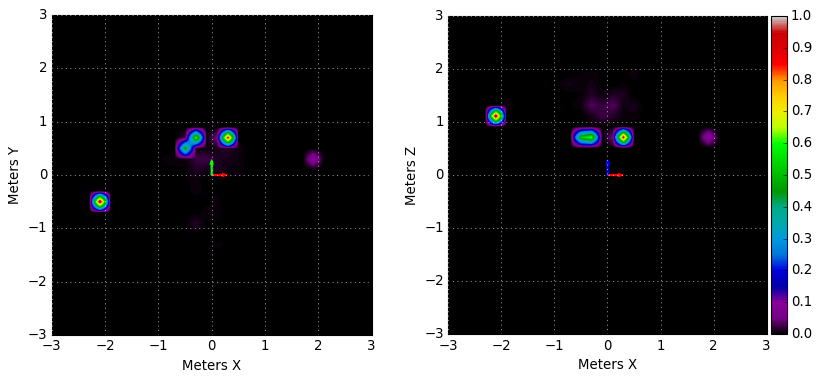

<Figure size 640x480 with 0 Axes>

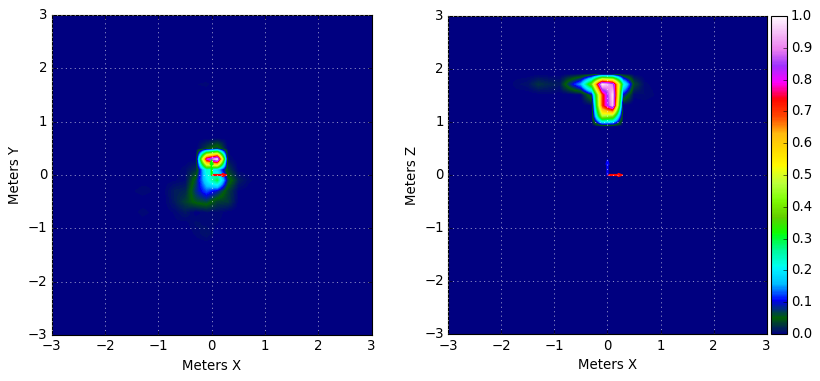

In [97]:
# MOCAP data

mocap_data = filterData(user_data, 'mocap', startTime)
heatmap_x_y, heatmap_x_z = generateHeatmapData(mocap_data, 2, 3, 4, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'nipy_spectral', limit)

# HOLO data

holo_data = filterData(user_data, 'holo', startTime)
holo_posdir_data = holo_data.loc[holo_data[2].str.contains('/gazedir')]

#pos: 3, 4, 5 dir:6, 7, 8 
heatmap_x_y, heatmap_x_z = generateHeatmapData(holo_posdir_data, 3, 4, 5, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'gist_ncar', limit)


<Figure size 640x480 with 0 Axes>

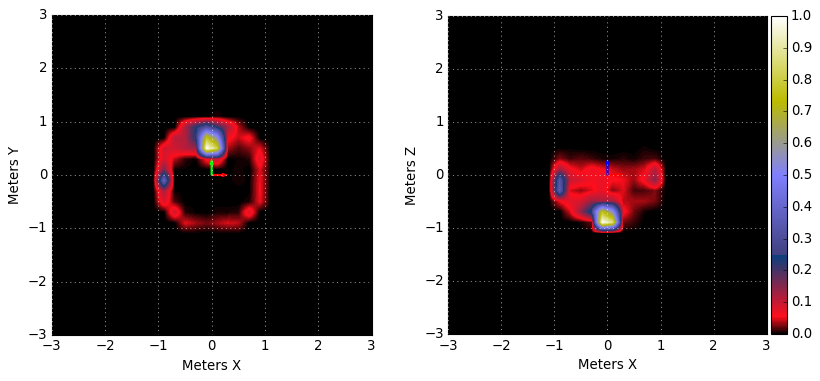

In [16]:
#pos: 3, 4, 5 dir:6, 7, 8 
heatmap_x_y, heatmap_x_z = generateHeatmapData(holo_posdir_data, 6, 7, 8, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'gist_stern', limit)

In [50]:
agents_data = filterData(user_data, 'agents', startTime)
agents_data = agents_data[agents_data[1].str.contains('agents')]# discard holo

In [58]:
def convertSaveInt(n):
    try:
        return int(n)
    except:
        return 0
    
def setAgentInfo(dic, id, time, state, x, y, z):
    if id not in dic:
        dic[id] = []
    info = {}    
    info['time'] = time
    info['state'] = state
    info['x'] = x
    info['y'] = y
    info['z'] = z
    dic[id].append(info)

agents_info = {}
init_index_row = 2
for index, row in agents_data.iterrows():
    agent_info_id = convertSaveInt(row[0 + init_index_row])
    agent_info_time = float(row[0])
    agent_info_state = convertSaveInt(row[1 + init_index_row])
    agent_info_x = convertSaveInt(row[2 + init_index_row])
    agent_info_y = convertSaveInt(row[3 + init_index_row])
    agent_info_z = convertSaveInt(row[4 + init_index_row])
    agents_size = convertSaveInt(row[5 + init_index_row])
    setAgentInfo(agents_info, agent_info_id, agent_info_time, agent_info_state, agent_info_x, agent_info_y, agent_info_z)
    for i in range(0, agents_size):
        agent_info_id = convertSaveInt(row[i * 4 + 6 + init_index_row])
        agent_info_time = float(row[0])
        agent_info_state = 2;#released state
        agent_info_x = convertSaveInt(row[i * 4 + 7 + init_index_row])
        agent_info_y = convertSaveInt(row[i * 4 + 8 + init_index_row])
        agent_info_z = convertSaveInt(row[i * 4 + 9 + init_index_row])
        setAgentInfo(agents_info, agent_info_id, agent_info_time, agent_info_state, agent_info_x, agent_info_y, agent_info_z)   

In [99]:
agent_df = pd.DataFrame(agents_info[0])
agent_df = agent_df[agent_df['state'] == 2]
heatmap_x_y, heatmap_x_z = generateHeatmapData(agent_df, 2, 3, 4, limit, step)    

<Figure size 640x480 with 0 Axes>

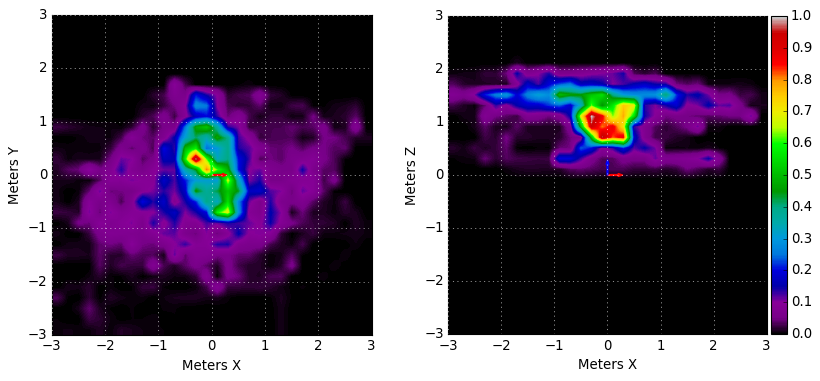

In [107]:
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'nipy_spectral', limit)